In [10]:
# Add to Python path
import sys
sys.path.append('/workspace/classify5')
print("Added /workspace/classify5 to Python path")

Added /workspace/classify5 to Python path


In [11]:
# Cell 1: Imports and Setup
import logging
from pathlib import Path
import sys
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from config.experiment_config import create_experiment_config
from experiments.traditional import TraditionalExperiment
from models.data import get_dataset
from models.factory import get_model
from utils.logging import setup_logging, get_logger

logger = get_logger(__name__)
setup_logging()

# Enable CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


2024-12-01 12:05:13,102 - root - INFO - Logging system initialized
Using device: cuda


In [12]:
# Cell 2: Configuration
CHECKPOINT_PATH = "checkpoints/gtsrb/gtsrb_best.pt"
LATEST_CHECKPOINT_PATH = "checkpoints/gtsrb/gtsrb_latest.pt"
EPOCHS = 100
BATCH_SIZE = 64
NUM_WORKERS = 8

# Create checkpoint directory
Path(CHECKPOINT_PATH).parent.mkdir(parents=True, exist_ok=True)

# Training transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

# Test transforms
transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

In [13]:
class TrainingVisualizer:
    def __init__(self, epochs):
        from IPython.display import clear_output
        self.epochs = epochs
        self.train_losses = []
        self.train_accs = []
        self.val_accs = []
        self.lrs = []
        
        # Create initial empty lists for plotting
        self.epoch_numbers = []
        
        # Close any existing plots
        plt.close('all')
        
        # Create new figure
        self.fig, (self.ax1, self.ax2, self.ax3) = plt.subplots(1, 3, figsize=(20, 6))
        self.setup_plots()
        plt.show()
        
    def setup_plots(self):
        # Loss plot
        self.line_loss, = self.ax1.plot([], [], 'b-', label='Loss')
        self.ax1.set_title('Training Loss', fontsize=12)
        self.ax1.set_xlabel('Epoch')
        self.ax1.set_ylabel('Loss')
        self.ax1.grid(True)
        self.ax1.set_xlim(0, self.epochs)
        self.ax1.set_ylim(0, 5)  # Set reasonable initial y-limits
        
        # Accuracy plot
        self.line_train_acc, = self.ax2.plot([], [], 'b-', label='Train')
        self.line_val_acc, = self.ax2.plot([], [], 'r-', label='Validation')
        self.ax2.set_title('Accuracy', fontsize=12)
        self.ax2.set_xlabel('Epoch')
        self.ax2.set_ylabel('Accuracy (%)')
        self.ax2.legend(loc='lower right')
        self.ax2.grid(True)
        self.ax2.set_xlim(0, self.epochs)
        self.ax2.set_ylim(0, 100)
        
        # Learning rate plot
        self.line_lr, = self.ax3.plot([], [], 'g-', label='LR')
        self.ax3.set_title('Learning Rate', fontsize=12)
        self.ax3.set_xlabel('Epoch')
        self.ax3.set_ylabel('Learning Rate')
        self.ax3.set_yscale('log')
        self.ax3.grid(True)
        self.ax3.set_xlim(0, self.epochs)
        self.ax3.set_ylim(1e-5, 1)
        
        plt.tight_layout()
    
    def update(self, epoch, train_loss, train_acc, val_acc, lr):
        from IPython.display import clear_output
        
        # Append new data
        self.epoch_numbers.append(epoch)
        self.train_losses.append(train_loss)
        self.train_accs.append(train_acc)
        self.val_accs.append(val_acc)
        self.lrs.append(lr)
        
        # Clear the output
        clear_output(wait=True)
        
        # Update the line data
        self.line_loss.set_data(self.epoch_numbers, self.train_losses)
        self.line_train_acc.set_data(self.epoch_numbers, self.train_accs)
        self.line_val_acc.set_data(self.epoch_numbers, self.val_accs)
        self.line_lr.set_data(self.epoch_numbers, self.lrs)
        
        # Adjust y-axis limits if needed
        if len(self.train_losses) > 0:
            max_loss = max(self.train_losses)
            self.ax1.set_ylim(0, max(5, max_loss * 1.1))
        
        # Display the plot
        plt.draw()
        plt.pause(0.1)
        display(self.fig)
        
        # Print current values
        print(f'Epoch {epoch}: Loss={train_loss:.3f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, LR={lr:.1e}')
    
    def save(self, path):
        self.fig.savefig(path, dpi=200, bbox_inches='tight')
        
    def close(self):
        plt.close(self.fig)

In [14]:
def train_model_interactive(model, train_loader, val_loader, epochs=200):
    """Train model with real-time visualization."""
    logger.info("Starting interactive training...")
    
    # Initialize training history
    history = {
        'train_losses': [],
        'train_accs': [],
        'val_accs': [],
        'lrs': []
    }
    
    # Enable cuDNN benchmarking
    cudnn.benchmark = True
    
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=5e-4,
        nesterov=True
    )
    
    milestones = [60, 120, 160]
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=milestones,
        gamma=0.2
    )
    
    # Try to load checkpoint
    start_epoch = 0
    best_acc = 0.0
    latest_path = Path(LATEST_CHECKPOINT_PATH)
    checkpoint_path = Path(CHECKPOINT_PATH)
    
    if latest_path.exists():
        logger.info(f"Resuming from latest checkpoint: {latest_path}")
        checkpoint = torch.load(latest_path, map_location=device)
    elif checkpoint_path.exists():
        logger.info(f"Resuming from checkpoint: {CHECKPOINT_PATH}")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    else:
        logger.info("No checkpoint found, starting from scratch")
        checkpoint = None
    
    if checkpoint is not None and isinstance(checkpoint, dict) and 'epoch' in checkpoint:
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint.get('acc', 0.0)
        # Load training history if available
        if 'history' in checkpoint:
            history = checkpoint['history']
            logger.info(f"Loaded training history of {len(history['train_losses'])} epochs")
        
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        elif 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        else:
            model.load_state_dict(checkpoint)
        if 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            # Move optimizer state to device
            for state in optimizer.state.values():
                for k, v in state.items():
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(device)
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        logger.info(f"Resuming from epoch {start_epoch} with best accuracy: {best_acc:.2f}%")
    
    model = model.to(device)
    model = torch.nn.DataParallel(model)
    
    scaler = torch.cuda.amp.GradScaler()
    visualizer = TrainingVisualizer(epochs)
    
    # Initialize visualizer with existing history if available
    if len(history['train_losses']) > 0:
        for i in range(len(history['train_losses'])):
            visualizer.update(
                i + 1,
                history['train_losses'][i],
                history['train_accs'][i],
                history['val_accs'][i],
                history['lrs'][i]
            )
    
    try:
        for epoch in range(start_epoch, epochs):
            # Training
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
            for inputs, targets in pbar:
                inputs = inputs.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                
                # Use torch.amp.autocast instead of torch.cuda.amp.autocast
                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                current_lr = optimizer.param_groups[0]['lr']
                pbar.set_postfix({
                    'loss': f'{train_loss/total:.3f}',
                    'acc': f'{100.*correct/total:.2f}%',
                    'lr': f'{current_lr:.3e}'
                })
            
            train_acc = 100.*correct/total
            
            # Validation
            model.eval()
            correct = 0
            total = 0
            
            with torch.no_grad(), torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                for inputs, targets in val_loader:
                    inputs = inputs.to(device, non_blocking=True)
                    targets = targets.to(device, non_blocking=True)
                    outputs = model(inputs)
                    
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()
            
            val_acc = 100.*correct/total
            logger.info(f'Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}% (lr={current_lr:.3e})')
            
            # Store metrics in history
            history['train_losses'].append(train_loss/len(train_loader))
            history['train_accs'].append(train_acc)
            history['val_accs'].append(val_acc)
            history['lrs'].append(current_lr)
            
            # Update visualization
            visualizer.update(epoch+1, train_loss/len(train_loader), train_acc, val_acc, current_lr)
            
            # Save checkpoint if best accuracy
            if val_acc > best_acc:
                logger.info(f'Saving checkpoint... ({val_acc:.2f}%)')
                best_acc = val_acc
                state = {
                    'model_state_dict': model.module.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'acc': val_acc,
                    'epoch': epoch,
                    'history': history  # Save training history
                }
                torch.save(state, CHECKPOINT_PATH)
                # Also save latest state
                torch.save(state, LATEST_CHECKPOINT_PATH)
            
            scheduler.step()
        
        # Save final plot
        visualizer.save('training_curves.png')
        
    except KeyboardInterrupt:
        logger.info('Training interrupted by user')
    finally:
        visualizer.close()
    
    logger.info(f'Training completed. Best accuracy: {best_acc:.2f}%')
    return best_acc > 50

In [15]:
# Cell 5: Setup Function
def setup_training(resume=True, subset_size=None):
    """Set up datasets and model for training."""
    # Get datasets
    train_dataset = get_dataset("gtsrb", train=True, transform=transform_train)
    val_dataset = get_dataset("gtsrb", train=False, transform=transform_test)
    
    # Apply subset if specified
    if subset_size:
        train_dataset = torch.utils.data.Subset(
            train_dataset, 
            range(min(subset_size, len(train_dataset)))
        )
        val_dataset = torch.utils.data.Subset(
            val_dataset,
            range(min(subset_size // 5, len(val_dataset)))
        )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        drop_last=True,
        persistent_workers=True,
        prefetch_factor=3
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE*2,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=3
    )
    
    # Create model and move to device
    model = get_model("gtsrb", "wrn-28-10")
    model = model.to(device)  # Move model to device before creating optimizer
    
    return model, train_loader, val_loader

<Figure size 640x480 with 0 Axes>

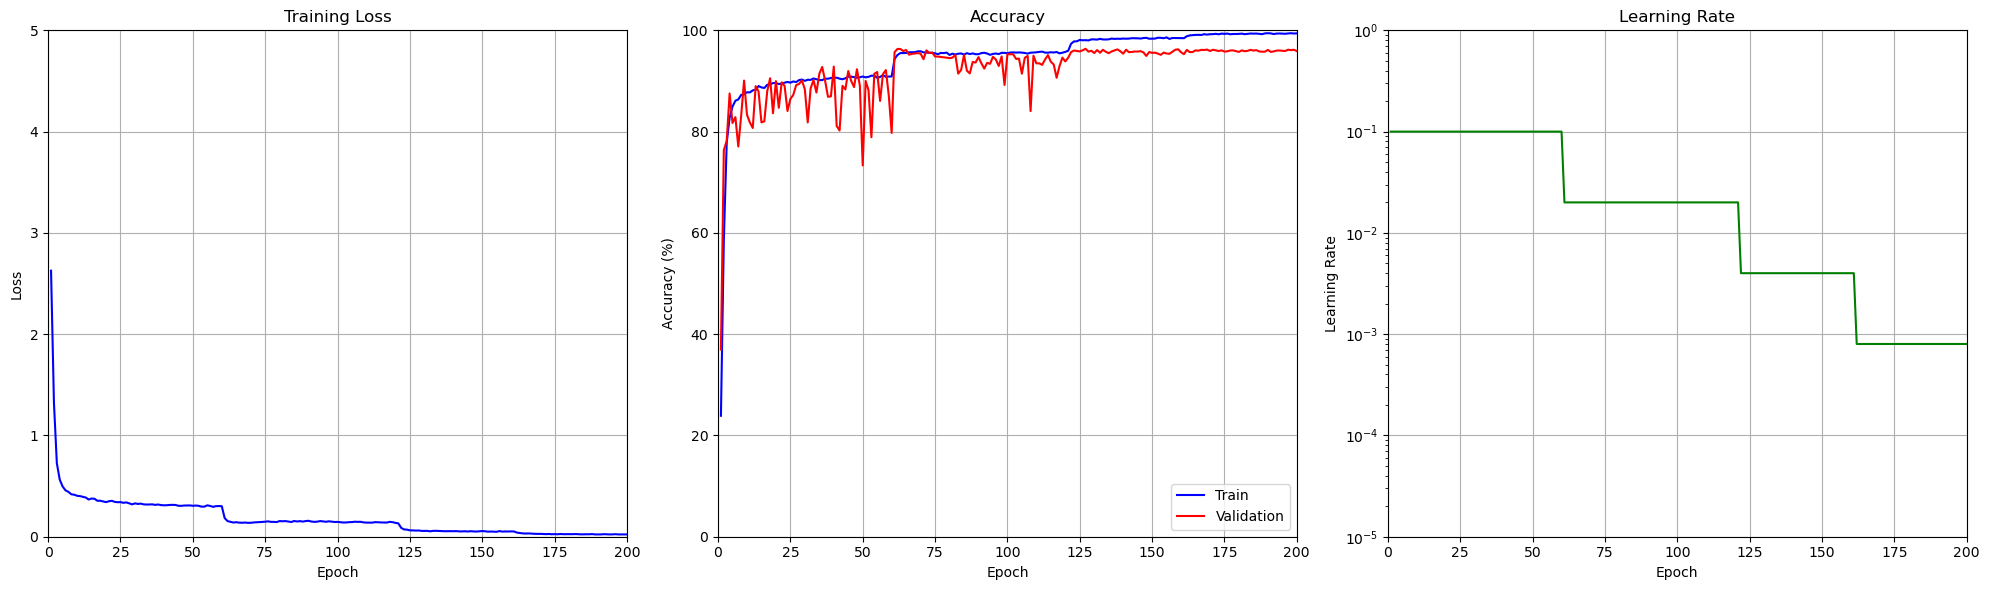

Epoch 200: Loss=0.023, Train Acc=99.41%, Val Acc=95.90%, LR=8.0e-04
2024-12-01 13:13:45,649 - __main__ - INFO - Training completed. Best accuracy: 96.36%


True

In [16]:
# Cell 6: Run Training
# Choose your scenario:

# Scenario 1: Resume training from checkpoint
# Run Training
model, train_loader, val_loader = setup_training()
train_model_interactive(model, train_loader, val_loader)

# Scenario 2: Train from scratch
# model, train_loader, val_loader = setup_training(resume=False)
# train_model_interactive(model, train_loader, val_loader, resume=False)

# Scenario 3: Train with subset
# model, train_loader, val_loader = setup_training(resume=True, subset_size=10000)
# train_model_interactive(model, train_loader, val_loader, resume=True)